# Late Fusion by Ambiguity Groups (POST Features, Weighted Fusion)

This notebook splits trials into ambiguity groups and runs late fusion for each group.

In [13]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## 1. Load and Extract Features (POST Features Only)

In [14]:
import re

preprocessing_dir = Path('../data/results/preprocessing')
preprocessing_files = sorted(preprocessing_dir.glob('preprocessing_*.json'))
raw_dir = Path('../data/json')
baseline_method = 't3_stable_pre_decision'

print(f"Found {len(preprocessing_files)} preprocessing files")

Found 10 preprocessing files


In [15]:
# Extract features with ambiguity information
all_physiology_features = []
all_behavior_features = []
all_outcomes = []
all_subject_ids = []
all_trial_ids = []
all_ambiguity = []

for preprocessed_file in preprocessing_files:
    with open(preprocessed_file, 'r') as f:
        preprocessed = json.load(f)
    
    subject_id = preprocessed['subject_id']
    print(f"\nProcessing subject: {subject_id}")
    
    matches = list(raw_dir.glob(f"*{subject_id.split('_')[-1]}.json"))
    pattern = subject_id.replace("_", ".*")
    match = next((f for f in matches if re.search(pattern, f.name)), None)
    if not match:
        continue
    
    with open(match, 'r') as f:
        raw_data = json.load(f)
    
    subject_trial_count = 0
    
    for trial_id, trial_data in preprocessed['trial_data'].items():
        method_data = trial_data['methods'][baseline_method]
        
        if method_data['success'] != True:
            continue
        
        raw_trial = raw_data['trials'][int(trial_id)-1]
        
        if not raw_trial['gamble details']['submitted']:
            continue
        
        # Extract pupil data
        time_aligned = np.array(trial_data['time_relative_to_submit'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        pupil_L = np.array(method_data['pupil_L_baselined'])
        pupil_R = np.array(method_data['pupil_R_baselined'])

        valid_mask = ~np.isnan(pupil_avg)
        pupil_avg_clean = pupil_avg[valid_mask]
        pupil_L_clean = pupil_L[valid_mask]
        pupil_R_clean = pupil_R[valid_mask]
        time_clean = time_aligned[valid_mask]

        if len(pupil_avg_clean) < 20:
            continue

        # POST-SUBMIT DATA ONLY
        post_submit_mask = (time_clean > 0) & (time_clean <= 2.0)
        pupil_post = pupil_avg_clean[post_submit_mask]
        pupil_L_post = pupil_L_clean[post_submit_mask]
        pupil_R_post = pupil_R_clean[post_submit_mask]
        time_post = time_clean[post_submit_mask]

        if len(pupil_post) < 5:
            continue

        pupil_velocity_post = np.diff(pupil_post) if len(pupil_post) > 1 else np.array([0])
        pupil_acceleration_post = np.diff(pupil_velocity_post) if len(pupil_velocity_post) > 1 else np.array([0])
        dilation_mask_post = pupil_velocity_post > 0 if len(pupil_velocity_post) > 0 else np.array([False])

        physiology_features = {
            'pupil_mean_post': np.mean(pupil_post),
            'pupil_std_post': np.std(pupil_post),
            'pupil_slope_post': np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0,
            'time_to_peak_post': time_post[np.argmax(pupil_post)] - time_post[0] if len(time_post) > 0 else 0,
            'pupil_cv_post': np.std(pupil_post) / np.abs(np.mean(pupil_post)) if (len(pupil_post) > 0 and np.mean(pupil_post) != 0) else 0,
            'pupil_velocity_mean_post': np.mean(np.abs(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_dilation_rate_post': np.max(pupil_velocity_post) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_constriction_rate_post': np.abs(np.min(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            'pupil_acceleration_std_post': np.std(pupil_acceleration_post) if len(pupil_acceleration_post) > 1 else 0,
            'pct_time_dilating_post': np.mean(dilation_mask_post) if len(dilation_mask_post) > 0 else 0,
            'num_dilation_peaks_post': np.sum(np.diff(np.sign(pupil_velocity_post)) > 0) if len(pupil_velocity_post) > 1 else 0,
            'eye_asymmetry_post': np.nanmean(np.abs(pupil_L_post - pupil_R_post)) if len(pupil_L_post) > 0 else 0,
            'eye_asymmetry_std_post': np.nanstd(pupil_L_post - pupil_R_post) if len(pupil_L_post) > 1 else 0,
        }
        
        # BEHAVIOR FEATURES
        gamble_params = raw_trial['gamble details']['gamble parameters']
        lct = raw_trial['lct']
        
        show_screen_time = None
        submit_time = None
        click_time = None
        
        for event in lct:
            if 'show screen' in event['event']:
                show_screen_time = event['time']
            elif 'gamble clicked' in event['event']:
                click_time = event['time']
            elif 'submit' in event['event']:
                submit_time = event['time']
        
        if show_screen_time is None or submit_time is None:
            continue
        
        reaction_time = (click_time - show_screen_time) if click_time else np.nan
        decision_time = (submit_time - show_screen_time)

        invest_ev = (gamble_params['invest amount 1'] * gamble_params['invest probability 1'] + 
                    gamble_params['invest amount 2'] * gamble_params['invest probability 2'])
        keep_ev = gamble_params['keep amount']
        ev_difference = invest_ev - keep_ev

        invest_variance = ((gamble_params['invest amount 1'] - invest_ev)**2 * gamble_params['invest probability 1'] +
                        (gamble_params['invest amount 2'] - invest_ev)**2 * gamble_params['invest probability 2'])
        
        final_choice = raw_trial['gamble details']['choices'][-1]['choice'] if len(raw_trial['gamble details']['choices']) > 0 else None
        chose_invest = 1 if final_choice == 'INVEST' else 0
        
        ambiguity = gamble_params['ambiguity']
        
        behavior_features = {
            'reaction_time': reaction_time if not np.isnan(reaction_time) else decision_time,
            'decision_time': decision_time,
            'ev_difference': ev_difference,
            'invest_variance': invest_variance,
            'ambiguity': ambiguity,
            'condition_social': 1 if gamble_params['condition'] == 'social' else 0,
            'risk_premium': ev_difference / np.sqrt(invest_variance) if invest_variance > 0 else 0,
        }
                
        outcome = chose_invest
        
        all_physiology_features.append(physiology_features)
        all_behavior_features.append(behavior_features)
        all_outcomes.append(outcome)
        all_subject_ids.append(subject_id)
        all_trial_ids.append(f"{trial_id}_{subject_id}")
        all_ambiguity.append(ambiguity)
        
        subject_trial_count += 1
    
    print(f"  Extracted {subject_trial_count} valid trials")

physio_df = pd.DataFrame(all_physiology_features)
physio_df.insert(0, 'subject_id', all_subject_ids)
physio_df.insert(1, 'trial_id', all_trial_ids)
physio_df['outcome'] = all_outcomes
physio_df['ambiguity'] = all_ambiguity

behavior_df = pd.DataFrame(all_behavior_features)
behavior_df.insert(0, 'subject_id', all_subject_ids)
behavior_df.insert(1, 'trial_id', all_trial_ids)
behavior_df['outcome'] = all_outcomes

print(f"\n{'='*80}")
print(f"Total trials: {len(physio_df)}")
print(f"Ambiguity distribution:\n{pd.Series(all_ambiguity).value_counts().sort_index()}")


Processing subject: 0927_0930_U9TEJGM
  Extracted 99 valid trials

Processing subject: 0928_1600_539136F
  Extracted 110 valid trials

Processing subject: 0928_1600_9M4VCHG
  Extracted 117 valid trials

Processing subject: 0928_1600_U9TEJGM
  Extracted 93 valid trials

Processing subject: 0930_1700_539136F
  Extracted 95 valid trials

Processing subject: 0930_1700_9M4VCHG
  Extracted 112 valid trials

Processing subject: 0930_1700_U9TEJGM
  Extracted 123 valid trials

Processing subject: 1005_1600_539136F
  Extracted 121 valid trials

Processing subject: 1005_1600_9M4VCHG
  Extracted 123 valid trials

Processing subject: 1005_1600_U9TEJGM
  Extracted 51 valid trials

Total trials: 1044
Ambiguity distribution:
0    347
3    342
6    355
Name: count, dtype: int64


## 2. Load Gaze Data

In [16]:
def extract_gaze_features_from_trial(eye_data):
    if not eye_data or len(eye_data) == 0:
        return None
    
    timestamps = np.array([s['time'] for s in eye_data])
    gaze_x_L = np.array([s.get('gazeL_X', np.nan) for s in eye_data])
    gaze_y_L = np.array([s.get('gazeL_Y', np.nan) for s in eye_data])
    gaze_x_R = np.array([s.get('gazeR_X', np.nan) for s in eye_data])
    gaze_y_R = np.array([s.get('gazeR_Y', np.nan) for s in eye_data])
    
    gaze_x = np.nanmean([gaze_x_L, gaze_x_R], axis=0)
    gaze_y = np.nanmean([gaze_y_L, gaze_y_R], axis=0)
    
    screen_x_L = np.array([s.get('pupilLSensorPosL_X', np.nan) for s in eye_data])
    screen_y_L = np.array([s.get('pupilLSensorPosL_Y', np.nan) for s in eye_data])
    screen_x_R = np.array([s.get('pupilLSensorPosR_X', np.nan) for s in eye_data])
    screen_y_R = np.array([s.get('pupilLSensorPosR_Y', np.nan) for s in eye_data])
    
    screen_x = np.nanmean([screen_x_L, screen_x_R], axis=0)
    screen_y = np.nanmean([screen_y_L, screen_y_R], axis=0)
    
    valid_L = np.array([s.get('validL', 0) for s in eye_data])
    valid_R = np.array([s.get('validR', 0) for s in eye_data])
    
    features = {}
    features['gaze_valid_pct'] = np.mean((valid_L > 0) & (valid_R > 0))
    
    valid_mask = (valid_L > 0) & (valid_R > 0)
    if valid_mask.sum() < 5:
        return None
    
    gaze_x_valid = gaze_x[valid_mask]
    gaze_y_valid = gaze_y[valid_mask]
    screen_x_valid = screen_x[valid_mask]
    screen_y_valid = screen_y[valid_mask]
    timestamps_valid = timestamps[valid_mask]
    
    features['gaze_x_mean'] = np.nanmean(gaze_x_valid)
    features['gaze_x_std'] = np.nanstd(gaze_x_valid)
    features['gaze_y_mean'] = np.nanmean(gaze_y_valid)
    features['gaze_y_std'] = np.nanstd(gaze_y_valid)
    features['screen_x_mean'] = np.nanmean(screen_x_valid)
    features['screen_x_std'] = np.nanstd(screen_x_valid)
    features['screen_y_mean'] = np.nanmean(screen_y_valid)
    features['screen_y_std'] = np.nanstd(screen_y_valid)
    
    dt = np.diff(timestamps_valid)
    dt[dt == 0] = 1e-6
    dx = np.diff(screen_x_valid)
    dy = np.diff(screen_y_valid)
    
    velocity = np.sqrt(dx**2 + dy**2) / dt
    features['gaze_velocity_mean'] = np.nanmean(velocity)
    features['gaze_velocity_std'] = np.nanstd(velocity)
    features['gaze_velocity_max'] = np.nanmax(velocity)
    
    acceleration = np.diff(velocity) / dt[:-1]
    features['gaze_acceleration_mean'] = np.nanmean(np.abs(acceleration))
    features['gaze_acceleration_std'] = np.nanstd(acceleration)
    
    fixation_mask = velocity < 30
    saccade_mask = velocity > 100
    features['fixation_ratio'] = np.mean(fixation_mask)
    features['saccade_ratio'] = np.mean(saccade_mask)
    features['saccade_count'] = np.sum(np.diff(saccade_mask.astype(int)) == 1)
    
    features['gaze_dispersion_x'] = np.nanmax(screen_x_valid) - np.nanmin(screen_x_valid)
    features['gaze_dispersion_y'] = np.nanmax(screen_y_valid) - np.nanmin(screen_y_valid)
    features['gaze_path_length'] = np.sum(np.sqrt(dx**2 + dy**2))
    
    return features

def map_subject_filename(json_filename):
    import re
    match = re.search(r'(\d{4})_(\d{4})_LCT_DESKTOP-([A-Z0-9]+)', json_filename)
    if match:
        date1, date2, desktop_id = match.groups()
        return f"{date1}_{date2}_{desktop_id}"
    return None

def extract_gaze_data(raw_json_files):
    all_gaze_data = []
    
    for file_path in raw_json_files:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        subject_id = map_subject_filename(file_path.name)
        if not subject_id:
            continue
        
        trials = data.get('trials', [])
        
        for trial_idx, trial in enumerate(trials):
            eye_data = trial.get('eye', [])
            if not eye_data:
                continue
            
            gamble_details = trial.get('gamble details', {})
            trial_id = str(gamble_details.get('trial', trial_idx))
            
            gaze_features = extract_gaze_features_from_trial(eye_data)
            if gaze_features is None:
                continue
            
            gaze_features['subject_id'] = subject_id
            gaze_features['trial_id'] = f"{trial_id}_{subject_id}"
            all_gaze_data.append(gaze_features)
    
    gaze_df = pd.DataFrame(all_gaze_data)
    print(f"Gaze: {len(gaze_df)} trials")
    return gaze_df

raw_json_dir = Path('../data/json')
raw_json_files = sorted(raw_json_dir.glob('*.json'))
gaze_df = extract_gaze_data(raw_json_files)

Gaze: 1383 trials


## 3. Merge and Create Ambiguity Groups

In [17]:
merged_df = physio_df.merge(
    behavior_df.drop(columns=['outcome', 'ambiguity']),
    on=['subject_id', 'trial_id'],
    how='inner'
)

merged_df = merged_df.merge(
    gaze_df,
    on=['subject_id', 'trial_id'],
    how='inner'
)

print(f"Merged data: {len(merged_df)} trials")
print(f"\nAmbiguity distribution:\n{merged_df['ambiguity'].value_counts().sort_index()}")

Merged data: 1044 trials

Ambiguity distribution:
ambiguity
0    347
3    342
6    355
Name: count, dtype: int64


In [18]:
# Create ambiguity groups
# Strategy: Group by quartiles or specific bins
merged_df['ambiguity_group'] = merged_df['ambiguity'].replace({0:'Low', 3:'Medium', 6:'High'})

print("\nAmbiguity group distribution:")
print(merged_df['ambiguity_group'].value_counts())


Ambiguity group distribution:
ambiguity_group
High      355
Low       347
Medium    342
Name: count, dtype: int64


## 4. Prepare Feature Sets

In [19]:
physio_cols = [c for c in merged_df.columns if c.endswith('_post')]
behavior_cols = ['reaction_time', 'decision_time', 'ev_difference', 
                 'invest_variance', 'condition_social', 'risk_premium']
gaze_cols = [c for c in merged_df.columns 
             if c.startswith('gaze_') or c.startswith('screen_') or 
             c in ['fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_valid_pct',
                   'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']]

print(f"Physiology (POST): {len(physio_cols)} features")
print(f"Behavior: {len(behavior_cols)} features")
print(f"Gaze: {len(gaze_cols)} features")

Physiology (POST): 13 features
Behavior: 6 features
Gaze: 20 features


## 5. Run Weighted Late Fusion for Each Ambiguity Group

In [20]:
def weighted_late_fusion(X_modalities, y, subjects, modality_names):
    """
    Weighted late fusion using LOSO cross-validation.
    """
    logo = LeaveOneGroupOut()
    base_models = [RandomForestClassifier(n_estimators=100, max_depth=5, 
                                          min_samples_split=10, min_samples_leaf=5, 
                                          random_state=42)
                   for _ in X_modalities]
    
    accs, f1s, all_weights = [], [], []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        train_probs, test_probs = [], []
        
        for X, model in zip(X_modalities, base_models):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train = y[train_idx]
            
            model.fit(X_train, y_train)
            train_probs.append(model.predict_proba(X_train)[:, 1])
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        train_probs = np.column_stack(train_probs)
        test_probs = np.column_stack(test_probs)
        y_train, y_test = y[train_idx], y[test_idx]
        
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        weights = meta.coef_[0]
        y_pred = meta.predict(test_probs)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        accs.append(acc)
        f1s.append(f1)
        all_weights.append(weights)
    
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    return {
        'accuracy': np.mean(accs),
        'accuracy_std': np.std(accs),
        'f1_score': np.mean(f1s),
        'f1_std': np.std(f1s),
        'weights': norm_weights,
        'n_trials': len(y)
    }

In [21]:
modality_names = ['Physiology (POST)', 'Behavior', 'Gaze']
group_results = {}

for group in ['Low', 'Medium', 'High']:
    print(f"\n{'='*80}")
    print(f"Ambiguity Group: {group}")
    print(f"{'='*80}")
    
    group_data = merged_df[merged_df['ambiguity_group'] == group]
    
    if len(group_data) < 20:
        print(f"Insufficient data ({len(group_data)} trials). Skipping.")
        continue
    
    # Check if we have enough subjects
    n_subjects = group_data['subject_id'].nunique()
    if n_subjects < 3:
        print(f"Insufficient subjects ({n_subjects}). Skipping.")
        continue
    
    print(f"Trials: {len(group_data)}")
    print(f"Subjects: {n_subjects}")
    print(f"Outcome distribution: {group_data['outcome'].value_counts().to_dict()}")
    
    X_physio = SimpleImputer(strategy='mean').fit_transform(group_data[physio_cols])
    X_behavior = SimpleImputer(strategy='mean').fit_transform(group_data[behavior_cols])
    X_gaze = SimpleImputer(strategy='mean').fit_transform(group_data[gaze_cols])
    y = group_data['outcome'].values
    subjects = group_data['subject_id'].values
    
    X_modalities = [X_physio, X_behavior, X_gaze]
    
    results = weighted_late_fusion(X_modalities, y, subjects, modality_names)
    group_results[group] = results
    
    print(f"\nResults:")
    print(f"  Accuracy: {results['accuracy']:.3f} ± {results['accuracy_std']:.3f}")
    print(f"  F1-Score: {results['f1_score']:.3f} ± {results['f1_std']:.3f}")
    print(f"\n  Modality Weights:")
    for name, w in zip(modality_names, results['weights']):
        print(f"    {name}: {w:.3f}")


Ambiguity Group: Low
Trials: 347
Subjects: 10
Outcome distribution: {1: 287, 0: 60}

Results:
  Accuracy: 0.838 ± 0.191
  F1-Score: 0.785 ± 0.255

  Modality Weights:
    Physiology (POST): 0.185
    Behavior: 0.205
    Gaze: 0.610

Ambiguity Group: Medium
Trials: 342
Subjects: 10
Outcome distribution: {1: 236, 0: 106}

Results:
  Accuracy: 0.664 ± 0.245
  F1-Score: 0.650 ± 0.277

  Modality Weights:
    Physiology (POST): 0.237
    Behavior: 0.151
    Gaze: 0.613

Ambiguity Group: High
Trials: 355
Subjects: 10
Outcome distribution: {0: 190, 1: 165}

Results:
  Accuracy: 0.633 ± 0.152
  F1-Score: 0.644 ± 0.148

  Modality Weights:
    Physiology (POST): 0.225
    Behavior: 0.113
    Gaze: 0.662


## 6. Compare Results Across Groups

In [22]:
if len(group_results) > 0:
    comparison_df = pd.DataFrame([
        {
            'Group': group,
            'N_Trials': results['n_trials'],
            'Accuracy': results['accuracy'],
            'Accuracy_Std': results['accuracy_std'],
            'F1-Score': results['f1_score'],
            'F1_Std': results['f1_std'],
            'Physiology_Weight': results['weights'][0],
            'Behavior_Weight': results['weights'][1],
            'Gaze_Weight': results['weights'][2]
        }
        for group, results in group_results.items()
    ])
    
    print("\n" + "="*80)
    print("COMPARISON ACROSS AMBIGUITY GROUPS")
    print("="*80)
    print(comparison_df.to_string(index=False))
else:
    print("No groups with sufficient data for comparison.")


COMPARISON ACROSS AMBIGUITY GROUPS
 Group  N_Trials  Accuracy  Accuracy_Std  F1-Score   F1_Std  Physiology_Weight  Behavior_Weight  Gaze_Weight
   Low       347  0.838089      0.190922  0.784874 0.255158           0.185060         0.204922     0.610018
Medium       342  0.663558      0.244672  0.649707 0.276747           0.236504         0.150954     0.612542
  High       355  0.632622      0.151738  0.643965 0.148343           0.224629         0.113330     0.662041


## 7. Visualizations

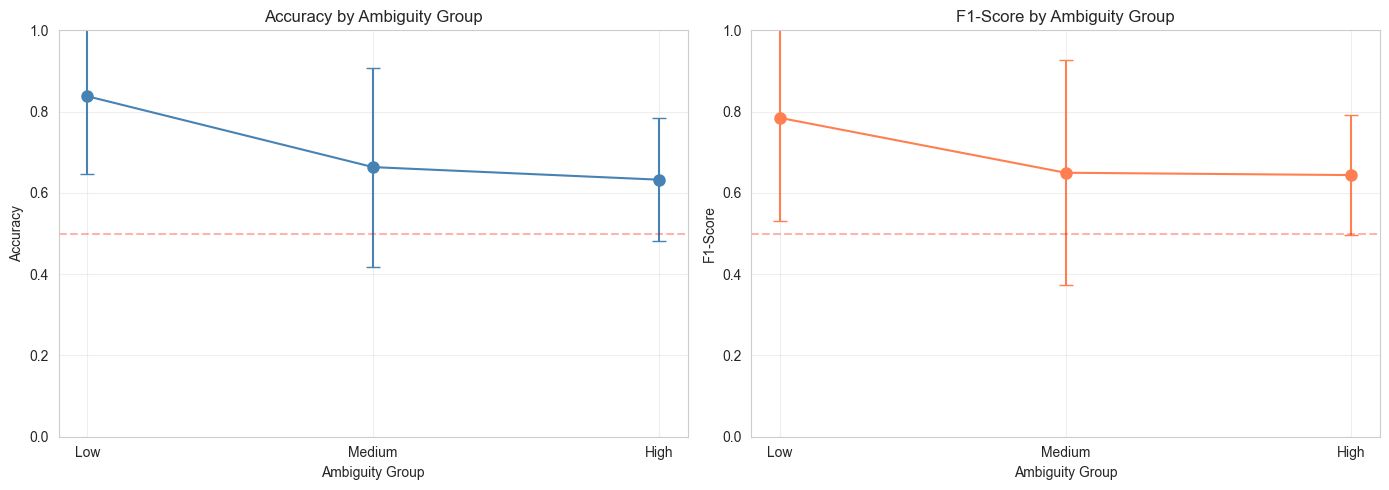

In [23]:
if len(group_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax = axes[0]
    ax.errorbar(comparison_df['Group'], comparison_df['Accuracy'], 
                yerr=comparison_df['Accuracy_Std'], fmt='o-', capsize=5, color='steelblue', markersize=8)
    ax.set_xlabel('Ambiguity Group')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by Ambiguity Group')
    ax.set_ylim([0, 1])
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    ax.grid(alpha=0.3)
    
    # F1-Score
    ax = axes[1]
    ax.errorbar(comparison_df['Group'], comparison_df['F1-Score'], 
                yerr=comparison_df['F1_Std'], fmt='o-', capsize=5, color='coral', markersize=8)
    ax.set_xlabel('Ambiguity Group')
    ax.set_ylabel('F1-Score')
    ax.set_title('F1-Score by Ambiguity Group')
    ax.set_ylim([0, 1])
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

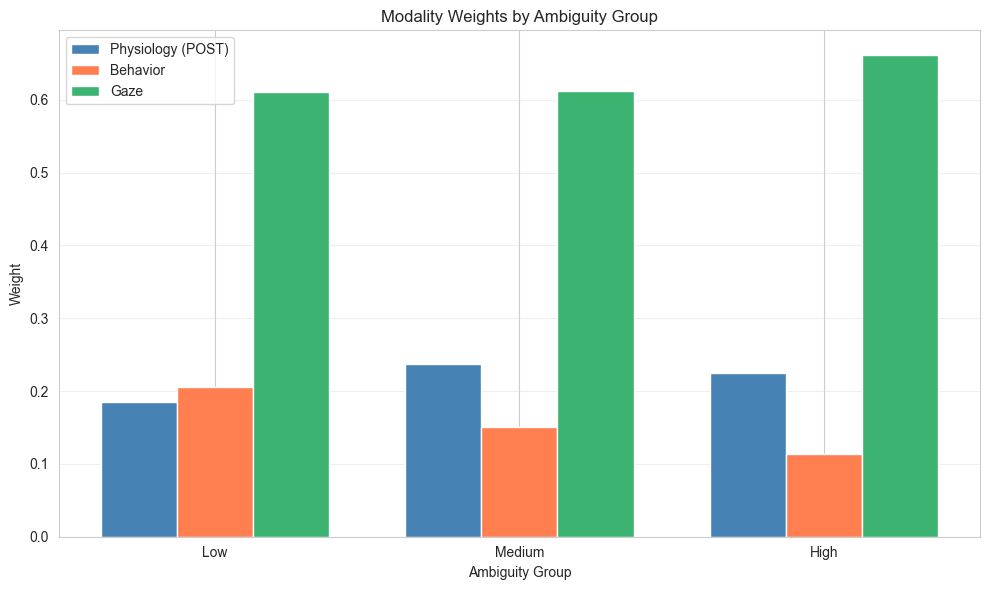

In [24]:
if len(group_results) > 0:
    # Modality weights by group
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(comparison_df))
    width = 0.25
    
    ax.bar(x - width, comparison_df['Physiology_Weight'], width, 
           label='Physiology (POST)', color='steelblue')
    ax.bar(x, comparison_df['Behavior_Weight'], width, 
           label='Behavior', color='coral')
    ax.bar(x + width, comparison_df['Gaze_Weight'], width, 
           label='Gaze', color='mediumseagreen')
    
    ax.set_xlabel('Ambiguity Group')
    ax.set_ylabel('Weight')
    ax.set_title('Modality Weights by Ambiguity Group')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Group'])
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()